In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.table import Table
import astropy.units as u
from astropy.io import fits

import nfft
import scipy.signal as signal

In [2]:
plt.style.use('notebook')

## Read in a TESS light curve

In [3]:
tin = Table.read('../data/aguirre_1sec.fits')
i0 = 14

In [4]:
tin[i0]

TIC,HIP,numax,Stnumax,Synumax,Delnu,StDelNu,SyDelNu,Vmag,e_Vmag,Teff,e_Teff,[Fe/H],e_[Fe/H],R,StR,SyR,M,StM,SyM,Age,StAge,SyAge,Ref,fname
,,uHz,uHz,uHz,uHz,uHz,uHz,mag,mag,K,K,[Sun],[Sun],solRad,solRad,solRad,solMass,solMass,solMass,Gyr,Gyr,Gyr,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,bytes85
175375523,114775,60.0,1.1,0.3,5.8,0.1,0.14,5.899,0.009,4660.0,80.0,0.26,0.08,9.0,0.3,0.58,1.38,0.09,0.21,4.5,0.76,1.35,2011A&A...536A..71J,../data/singletess_lightcurve/tess2018234235059-s0002-0000000175375523-0121-s_lc.fits


In [5]:
t = Table(fits.getdata(tin['fname'][i0], ignore_missing_end=True))

tm = t['TIME']
fm = t['PDCSAP_FLUX']
fm = fm - np.nanmean(fm)
ind_finite = np.isfinite(fm)
tm = tm[ind_finite]
fm = fm[ind_finite]
ivar = (t['PDCSAP_FLUX_ERR'][ind_finite])**-2

## Non-uniform FFT

In [6]:
# set up fine frequency grid
N = 600
eta = 0.01
N = int(N/eta)
k_iday = (-int(N/2) + np.arange(N))*eta
k = (k_iday*u.day**-1).to(u.uHz)

In [7]:
# calculate NFFT amplitudes
f_lc = nfft.nfft_adjoint(tm*eta, fm, len(k))
amp = np.sqrt(f_lc.real**2 + f_lc.imag**2)        

## Lomb-Scargle periodogram

In [8]:
ind_positive = k_iday>0
frlin = k_iday[ind_positive]
freq = frlin * 2*np.pi

In [9]:
pgram = signal.lombscargle(tm, fm, freq, normalize=True)

## Forward model

In [10]:
def ln_profile_like_K_freqs(ts, ys, yivars, nu, deltanu, K=3):
    """Likelihood for a comb of K frequencies centered on nu and separated by deltanu (solves for the amplitudes)"""
    
    assert len(ts) == len(ys)
    
    halfK = (K - 1) // 2
    thisK = 2 * halfK + 1
    A = np.zeros((len(ts), 2 * thisK + 1))
    
    for k in range(thisK):
        f = nu - halfK * deltanu + k * deltanu
        A[:, 2 * k]     = np.cos(2. * np.pi * f * ts)
        A[:, 2 * k + 1] = np.sin(2. * np.pi * f * ts)
    
    A[:, -1] = 1.
    resid = ys - np.dot(A, np.linalg.solve(np.dot(A.T * yivars, A), np.dot(A.T * yivars, ys)))
    
    return -0.5 * np.sum(yivars * resid ** 2)

In [11]:
# select only frequencies in the relevant range (to save on computation time)
ind_xrange = (k>20*u.uHz) & (k<100*u.uHz)
freqs = k[ind_xrange]
freqs_iday = k_iday[ind_xrange]

# solve for a variety of Delta nu
Ndfreq = 10
dfreqs = np.linspace(1,10,Ndfreq)*u.uHz
dfreqs_iday = dfreqs.to(u.day**-1).value

K0 = 3

In [12]:
fll = np.empty((Ndfreq, np.size(freqs)))
for i in range(Ndfreq):
    fll[i] = np.array([ln_profile_like_K_freqs(tm, fm, ivar, f, dfreqs_iday[i], K=K0) for f in freqs_iday])

## Frequency spectra

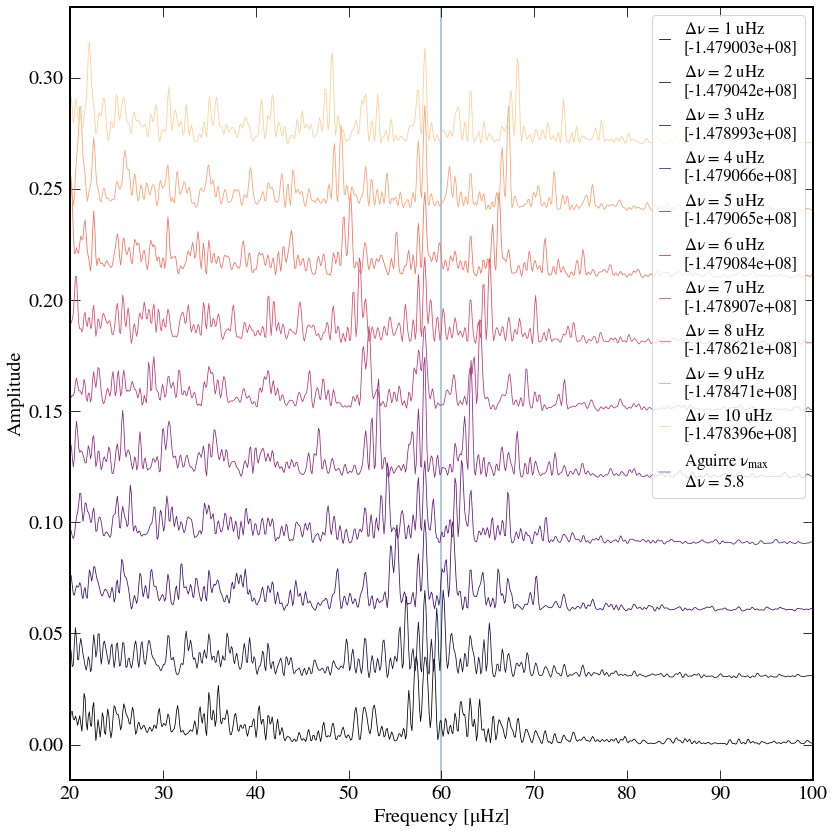

In [13]:
# compare forward models of the light curve assuming different Delta nu
cmap = mpl.cm.magma

plt.figure(figsize=(12,12))

for i in range(Ndfreq):
    plt.plot(k[ind_xrange], 0.03*i+(fll[i]-np.min(fll[i]))*4e-6, '-', color=cmap(i/Ndfreq), lw=0.8,
             label='$\Delta\\nu$ = {:.0f}\n[{:e}]'.format(dfreqs[i], np.sum(fll[i])))
plt.axvline(tin['numax'][i0], label='Aguirre $\\nu_{{max}}$\n$\Delta\\nu$ = {:.1f}'.format(tin['Delnu'][i0]),
            zorder=0, alpha=0.5)

plt.legend(fontsize='small', handlelength=0.7)
plt.xlim(20,100)
# plt.ylim(0, 0.05)

plt.xlabel('Frequency [$\mu$Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()

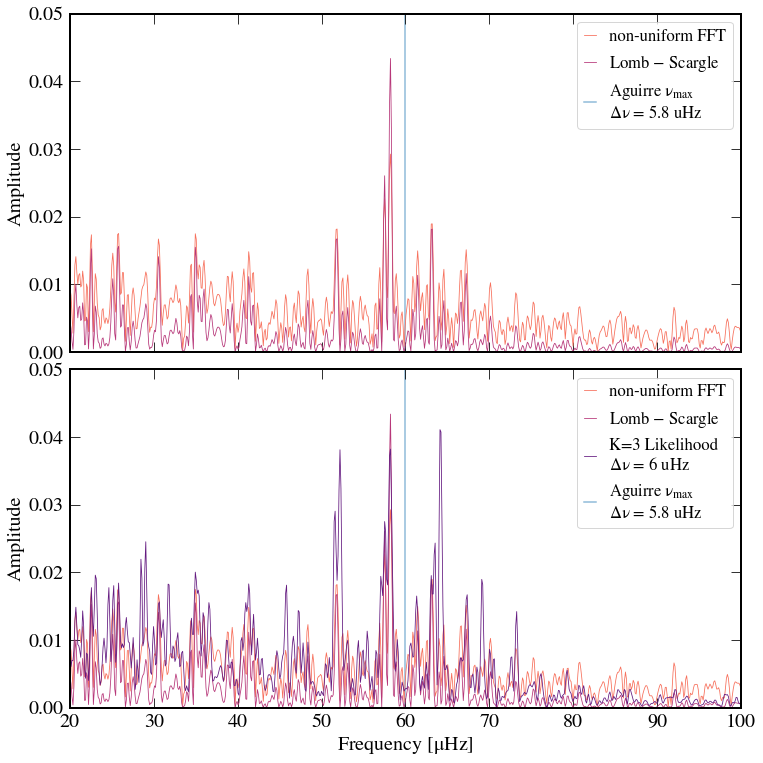

In [14]:
# compare the three spectral analyses of the light curve
cmap = mpl.cm.magma
iclose = 5

fig, ax = plt.subplots(2,1,figsize=(11,11), sharex=True, sharey=True)

for i in range(2):
    plt.sca(ax[i])
    plt.plot(k, amp*1.5e-8, '-', color=cmap(0.7), lw=0.8, label='non-uniform FFT')
    plt.plot(k[ind_positive], pgram, '-', color=cmap(0.5), lw=0.8, label='Lomb $-$ Scargle')
    if i==1:
        plt.plot(k[ind_xrange], (fll[iclose]-np.min(fll[iclose]))*4e-6, '-', color=cmap(0.3), lw=0.8,
             label='K=3 Likelihood\n$\Delta\\nu$ = {:.0f}'.format(dfreqs[iclose]))

    plt.axvline(tin['numax'][i0], label='Aguirre $\\nu_{{max}}$\n$\Delta\\nu$ = {:.1f} uHz'.format(tin['Delnu'][i0]),
                zorder=0, alpha=0.5)
    plt.ylabel('Amplitude')
    plt.legend(fontsize='small', handlelength=0.7)


plt.xlim(20,100)
plt.ylim(0, 0.05)
plt.xlabel('Frequency [$\mu$Hz]')

plt.tight_layout(h_pad=0)